##### Notebook 2: Model Training

Welcome to Notebook 2 of this recommendation system project!

In Notebook 1, we performed exploratory data analysis (EDA), and visualized various aspects of the data to gain insights into our anime recommendation problem.

In this notebook, we will focus on training the recommendation model. By separating the model training into a separate notebook, we ensure better memory management and organization of the project.

Let's dive in!

Note: If you haven't gone through Notebook 1 yet, I highly recommend you do so to understand the data and insights gained before moving on to the model training phase.

[Click here to access Notebook 1: Exploratory Data Analysis and Dataset Preparation](https://www.kaggle.com/code/dbdmobile/anime-recommendation-1)

In [1]:
!pip install wordcloud -q

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
### Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Import necessary modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

## Import necessary modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

D0728 06:09:38.754221925      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0728 06:09:38.754246530      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0728 06:09:38.754250633      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0728 06:09:38.754253928      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0728 06:09:38.754257091      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0728 06:09:38.754260663      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0728 06:09:38.754263782      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0728 06:09:38.

In [3]:
# Load the dataset
df=pd.read_csv('/kaggle/input/myanimelist-dataset/users-score-2023.csv', usecols=["user_id","anime_id","rating"])
print("Shape of the Dataset:",df.shape)
df.head()

Shape of the Dataset: (24325191, 3)


,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [4]:
# Checking if there are any duplicate rows
duplicated_rows = df[df.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [user_id, anime_id, rating]
Index: []


In [5]:
# Calculating the average score
avg_score = np.mean(df['rating'])
print('Average Score:', avg_score)

Average Score: 7.622930072779285


# Data Preprocessing

In [6]:
# Scaling our "rating" column
# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'score' column between 0 and 1
df['scaled_score'] = scaler.fit_transform(df[['rating']])

In [7]:
# Encoding categorical data

## Encoding user IDs
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user_id"])
num_users = len(user_encoder.classes_)

## Encoding anime IDs
anime_encoder = LabelEncoder()
df["anime_encoded"] = anime_encoder.fit_transform(df["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))
print("Minimum rating: {}, Maximum rating: {}".format(min(df['rating']), max(df['rating'])))

Number of unique users: 270033, Number of unique anime: 16500
Minimum rating: 1, Maximum rating: 10


# Model training (collaborative filtering)

In [8]:
# Shuffle the dataset
df = shuffle(df, random_state=100)

# Create feature matrix X and target variable y
X = df[['user_encoded', 'anime_encoded']].values
y = df["scaled_score"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (24325191, 2)
Shape of y: (24325191,)


In [9]:
test_set_size = 10000  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=73)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 24315191
Number of samples in the test set: 10000


In [10]:
# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [11]:
# Setting TPU_INIT flag
USE_TPU = True

# Checking if TPU is initialized
if USE_TPU:
    # If tpu is connected then start creating TPUStrategy
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
else:
    !nvidia-smi
    
# Print the TensorFlow version
tf_version = tf.__version__
print(f"TensorFlow version: {tf_version}")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


TensorFlow version: 2.12.0


In [12]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)
    
    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)
    
    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)
    
    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])
    
    return model
# Checking if TPU is initialized and create the model accordingly
if USE_TPU:
    with tpu_strategy.scope():
        model = RecommenderNet(num_users, num_animes)
else:
    model = RecommenderNet(num_users, num_animes)

# Printing my model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_encoded (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 anime_encoded (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       34564224    ['user_encoded[0][0]']           
                                                                                                  
 anime_embedding (Embedding)    (None, 1, 128)       2112000     ['anime_encoded[0][0]']          
                                                                                              

In [13]:
## Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Adjust the maximum learning rate and batch size if using TPU
if USE_TPU:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = '/kaggle/working/myanimeweights.h5'

# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [14]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20


2023-07-28 06:10:53.474547: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-28 06:10:53.657305: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


304/304 [==============================] - ETA: 0s - loss: 0.6882 - mae: 0.2592 - mse: 0.0873

2023-07-28 06:11:13.539485: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-28 06:11:13.697971: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


304/304 [==============================] - 24s 46ms/step - loss: 0.6882 - mae: 0.2592 - mse: 0.0873 - val_loss: 0.6858 - val_mae: 0.2566 - val_mse: 0.0857 - lr: 1.0000e-05
Epoch 2/20
304/304 [==============================] - 7s 22ms/step - loss: 0.6604 - mae: 0.2331 - mse: 0.0734 - val_loss: 0.6333 - val_mae: 0.2073 - val_mse: 0.0596 - lr: 8.8000e-05
Epoch 3/20
304/304 [==============================] - 7s 23ms/step - loss: 0.5989 - mae: 0.1705 - mse: 0.0437 - val_loss: 0.5787 - val_mae: 0.1485 - val_mse: 0.0342 - lr: 1.6600e-04
Epoch 4/20
304/304 [==============================] - 7s 22ms/step - loss: 0.5617 - mae: 0.1299 - mse: 0.0281 - val_loss: 0.5477 - val_mae: 0.1146 - val_mse: 0.0224 - lr: 2.4400e-04
Epoch 5/20
304/304 [==============================] - 7s 23ms/step - loss: 0.5393 - mae: 0.1062 - mse: 0.0196 - val_loss: 0.5403 - val_mae: 0.1068 - val_mse: 0.0197 - lr: 3.2200e-04
Epoch 6/20
304/304 [==============================] - 7s 22ms/step - loss: 0.5304 - mae: 0.0968 - ms

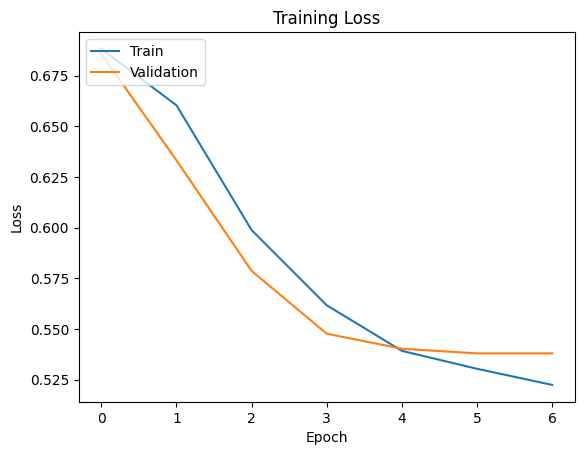

In [15]:
# Training results visualization

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Recommendation:

In [16]:
def extract_weights(name, model):
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)
    
    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]
    
    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    
    return weights

# Extract weights for anime embeddings
anime_weights = extract_weights('anime_embedding', model)
# Extract weights for user embeddings
user_weights = extract_weights('user_embedding', model)

#### Reading the whole dataset

In [17]:
df_anime=pd.read_csv('/kaggle/input/myanimelist-dataset/anime-dataset-2023.csv')

#### Now I want my model to recommend only those animes that have been rated by at least a certain number of users, which I will set as the threshold. This threshold helps ensure that the recommended anime titles have received a sufficient number of ratings, indicating a certain level of popularity or user engagement.

In [18]:
popularity_threshold = 50
df_anime= df_anime.query('Members >= @popularity_threshold')
print(df_anime.shape)
df_anime.head(3)      # only give rating of those movies for which atleast 200 user have rated

(22879, 24)


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...


# 1: Item Based Recommendation

In [19]:
def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        anime_row = df_anime[df_anime['Name'] == name].iloc[0]
        index = anime_row['anime_id']
        encoded_index = anime_encoder.transform([index])[0]
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1            
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        print('Animes closest to {}'.format(name))
        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        
        for close in closest:
            decoded_id = anime_encoder.inverse_transform([close])[0]
            anime_frame = df_anime[df_anime['anime_id'] == decoded_id]
            
            anime_name = anime_frame['Name'].values[0]
            english_name = anime_frame['English name'].values[0]
            name = english_name if english_name != "UNKNOWN" else anime_name
            genre = anime_frame['Genres'].values[0]
            Synopsis = anime_frame['Synopsis'].values[0]
            similarity = dists[close]
            similarity = "{:.2f}%".format(similarity * 100)
            SimilarityArr.append({"Name": name, "Similarity": similarity, "Genres": genre, "Synopsis":Synopsis})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="Similarity", ascending=False)
        return Frame[Frame.Name != name]
    except:
        print('{} not found in Anime list'.format(name))

pd.set_option('display.max_colwidth', None)

In [20]:
find_similar_animes('Tensei shitara Slime Datta Ken', n=5, neg=False)  # That Time I Got Reincarnated as a Slime

Animes closest to Tensei shitara Slime Datta Ken


,Name,Similarity,Genres,Synopsis
4,That Time I Got Reincarnated as a Slime Season 2,84.75%,"Action, Adventure, Comedy, Fantasy","Taking a break from his time as a teacher, the powerful slime Rimuru Tempest returns to his kingdom, eponymously named Tempest, just in time to begin negotiations with a nearby nation—the Kingdom of Eurazania. While the negotiations are anything but peaceful, they do end successfully, allowing Rimuru to return and finish teaching. When trying to again return to Tempest, this time permanently, Rimuru is stopped by a mysterious figure who is somehow able to constrain the many magical abilities he has at his disposal. \n\nIn Tempest, the situation is even worse. A group of unknown humans has invaded the land and are assaulting its citizens, both influential and innocent. They are not just trying to bring harm either—they have the intent to kill. Can Rimuru overcome his powerful and dangerous foe and return to Tempest before it is too late?"
3,That Time I Got Reincarnated as a Slime Season 2 Part 2,79.61%,"Action, Adventure, Comedy, Fantasy","The nation of Tempest is in a festive mood after successfully overcoming the surprise attack from the Falmuth Army and the Western Holy Church. Beyond the festivities lies a meeting between Tempest and its allies to decide the future of the Nation of Monsters. The aftermath of the Falmuth invasion, Milim Nava's suspicious behavior, and the disappearance of Demon Lord Carrion—the problems seem to keep on piling up.\n\nRimuru Tempest, now awakened as a ""True Demon Lord,"" decides to go on the offensive against Clayman. With the fully revived ""Storm Dragon"" Veldora, ""Ultimate Skill"" Raphael, and other powerful comrades, the ruler of the Tempest is confident in taking down his enemies one by one until he can face the man pulling the strings."
2,Overlord III,74.71%,"Action, Adventure, Fantasy","Following the horrific assault on the Re-Estize capital city, the Guardians of the Great Tomb of Nazarick return home to their master Ainz Ooal Gown. After months of laying the groundwork, they are finally ready to set their plans of world domination into action.\n\nAs Ainz's war machine gathers strength, the rest of the world keeps moving. The remote Carne Village, which Ainz once saved from certain doom, continues to prosper despite the many threats on its doorstep. And in the northeastern Baharuth Empire, a certain Bloody Emperor sets his sights on the rising power of Nazarick.\n\nBlood is shed, heroes fall, and nations rise. Can anyone, or anything, challenge the supreme power of Ainz Ooal Gown?"
1,The Rising of the Shield Hero,73.89%,"Action, Adventure, Drama, Fantasy","The Four Cardinal Heroes are a group of ordinary men from modern-day Japan summoned to the kingdom of Melromarc to become its saviors. Melromarc is a country plagued by the Waves of Catastrophe that have repeatedly ravaged the land and brought disaster to its citizens for centuries. The four heroes are respectively bestowed a sword, spear, bow, and shield to vanquish these Waves. Naofumi Iwatani, an otaku, becomes cursed with the fate of being the ""Shield Hero."" Armed with only a measly shield, Naofumi is belittled and ridiculed by his fellow heroes and the kingdom's people due to his weak offensive capabilities and lackluster personality.\n\nWhen the heroes are provided with resources and comrades to train with, Naofumi sets out with the only person willing to train alongside him, Malty Melromarc. He is soon betrayed by her, however, and becomes falsely accused of taking advantage of her. Naofumi then becomes heavily discriminated against and hated by the people of Melromarc for something he didn't do. With a raging storm of hurt and mistrust in his heart, Naofumi begins his journey of strengthening himself and his reputation. Further along however, the difficulty of being on his own sets in, so Naofumi buys a demi-human slave on the verge of death named Raphtalia to accompany him on his travels.\n\nAs

In [21]:
find_similar_animes('Shigatsu wa Kimi no Uso', n=5, neg=False) # Your Lie in April

Animes closest to Shigatsu wa Kimi no Uso


,Name,Similarity,Genres,Synopsis
4,Your Name.,88.96%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
3,A Silent Voice,88.10%,"Award Winning, Drama","As a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye.\n\nNow in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends.\n\nKoe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
2,Anohana: The Flower We Saw That Day,84.63%,"Drama, Supernatural","Jinta Yadomi is peacefully living as a recluse, spending his days away from school and playing video games at home instead. One hot summer day, his childhood friend, Meiko ""Menma"" Honma, appears and pesters him to grant a forgotten wish. He pays her no mind, which annoys her, but he doesn't really care. After all, Menma already died years ago.\n\nAt first, Jinta thinks that he is merely hallucinating due to the summer heat, but he is later on convinced that what he sees truly is the ghost of Menma. Jinta and his group of childhood friends grew apart after her untimely death, but they are drawn together once more as they try to lay Menma's spirit to rest. Re-living their pain and guilt, will they be able to find the strength to help not only Menma move on—but themselves as well?"
1,ERASED,84.62%,"Mystery, Supernatural, Suspense","When tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives.\n \nHowever, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right.\n \nBoku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."
0,Steins;Gate,84.03%,"Drama, Sci-Fi, Suspense","Eccentric scientist Rintarou Okabe has a never-ending thirst for scientific exploration. Together with his ditzy but well-meaning friend Mayuri Shiina and his roommate Itaru Hashida, Rintarou founds the Future Gadget Laboratory in the hopes of creating technological innovations t

In [22]:
find_similar_animes('One Punch Man', n=5, neg=False)

Animes closest to One Punch Man


,Name,Similarity,Genres,Synopsis
4,Hunter x Hunter,84.42%,"Action, Adventure, Fantasy","Hunters devote themselves to accomplishing hazardous tasks, all from traversing the world's uncharted territories to locating rare items and monsters. Before becoming a Hunter, one must pass the Hunter Examination—a high-risk selection process in which most applicants end up handicapped or worse, deceased.\n\nAmbitious participants who challenge the notorious exam carry their own reason. What drives 12-year-old Gon Freecss is finding Ging, his father and a Hunter himself. Believing that he will meet his father by becoming a Hunter, Gon takes the first step to walk the same path.\n\nDuring the Hunter Examination, Gon befriends the medical student Leorio Paladiknight, the vindictive Kurapika, and ex-assassin Killua Zoldyck. While their motives vastly differ from each other, they band together for a common goal and begin to venture into a perilous world."
3,Gintama: The Movie: The Final Chapter: Be Forever Yorozuya,82.01%,"Action, Comedy, Sci-Fi","When Gintoki apprehends a movie pirate at a premiere, he checks the camera's footage and finds himself transported to a bleak, post-apocalyptic version of Edo, where a mysterious epidemic called the ""White Plague"" has ravished the world's population. It turns out that the movie pirate wasn't a pirate after all—it was an android time machine, and Gintoki has been hurtled five years into the future! Shinpachi and Kagura, his Yorozuya cohorts, have had a falling out and are now battle-hardened solo vigilantes and he himself has been missing for years, disappearing without a trace after scribbling a strange message in his journal.\n\nSetting out in the disguise given to him by the android time machine, Gintoki haphazardly reunites the Yorozuya team to investigate the White Plague, and soon discovers that the key to saving the future lies in the darkness of his own past. Determined to confront a powerful foe, he makes an important discovery—with a ragtag band of friends and allies at his side, he doesn't have to fight alone."
2,Steins;Gate,81.36%,"Drama, Sci-Fi, Suspense","Eccentric scientist Rintarou Okabe has a never-ending thirst for scientific exploration. Together with his ditzy but well-meaning friend Mayuri Shiina and his roommate Itaru Hashida, Rintarou founds the Future Gadget Laboratory in the hopes of creating technological innovations that baffle the human psyche. Despite claims of grandeur, the only notable ""gadget"" the trio have created is a microwave that has the mystifying power to turn bananas into green goo.\n\nHowever, when Rintarou decides to attend neuroscientist Kurisu Makise's conference on time travel, he experiences a series of strange events that lead him to believe that there is more to the ""Phone Microwave"" gadget than meets the eye. Apparently able to send text messages into the past using the microwave, Rintarou dabbles further with the ""time machine,"" attracting the ire and attention of the mysterious organization SERN.\n\nDue to the novel discovery, Rintarou and his friends find themselves in an ever-present danger. As he works to mitigate the damage his invention has caused to the timeline, he is not only fighting a battle to save his loved ones, but also one against his degrading sanity."
1,Gintama Season 5,81.08%,"Action, Comedy, Sci-Fi","After joining the resistance against the bakufu, Gintoki and the gang are in hiding, along with Katsura and his Joui rebels. The Yorozuya is soon approached by Nobume Imai and two members of the Kiheitai, who explain that the Harusame pirates have turned against 7th Division Captain Kamui and their former ally Takasugi. The Kiheitai present Gintoki with a job: find Takasugi, who has been missing since his ship was ambushed in a Harusame raid. Nobume also makes a stunning revelation regarding the Tendoushuu, a secret organization pulling the strings of numerous factions, and their leader Utsuro, the shadowy figure with an uncanny

In [23]:
find_similar_animes('Mushoku Tensei: Isekai Ittara Honki Dasu', n=5, neg=False)

Animes closest to Mushoku Tensei: Isekai Ittara Honki Dasu


,Name,Similarity,Genres,Synopsis
4,Mushoku Tensei: Jobless Reincarnation Part 2,91.07%,"Drama, Fantasy, Ecchi","After the mysterious mana calamity, Rudeus Greyrat and his fierce student Eris Boreas Greyrat are teleported to the Demon Continent. There, they team up with their newfound companion Ruijerd Supardia—the former leader of the Superd's Warrior group—to form ""Dead End,"" a successful adventurer party. Making a name for themselves, the trio journeys across the continent to make their way back home to Fittoa.\n\nFollowing the advice he received from the faceless god Hitogami, Rudeus saves Kishirika Kishirisu, the Great Emperor of the Demon World, who rewards him by granting him a strange power. Now, as Rudeus masters the powerful ability that offers a number of new opportunities, it might prove to be more than what he bargained for when unexpected dangers threaten to hinder their travels."
3,[Oshi No Ko],69.33%,"Drama, Supernatural","In the entertainment world, celebrities often show exaggerated versions of themselves to the public, concealing their true thoughts and struggles beneath elaborate lies. Fans buy into these fabrications, showering their idols with undying love and support, until something breaks the illusion. Sixteen-year-old rising star Ai Hoshino of pop idol group B Komachi has the world captivated; however, when she announces a hiatus due to health concerns, the news causes many to become worried.\n\nAs a huge fan of Ai, gynecologist Gorou Amemiya cheers her on from his countryside medical practice, wishing he could meet her in person one day. His wish comes true when Ai shows up at his hospital—not sick, but pregnant with twins! While the doctor promises Ai to safely deliver her children, he wonders if this encounter with the idol will forever change the nature of his relationship with her."
2,Demon Slayer: Kimetsu no Yaiba Entertainment District Arc,67.65%,"Action, Fantasy","The devastation of the Mugen Train incident still weighs heavily on the members of the Demon Slayer Corps. Despite being given time to recover, life must go on, as the wicked never sleep: a vicious demon is terrorizing the alluring women of the Yoshiwara Entertainment District. The Sound Pillar, Tengen Uzui, and his three wives are on the case. However, when he soon loses contact with his spouses, Tengen fears the worst and enlists the help of Tanjirou Kamado, Zenitsu Agatsuma, and Inosuke Hashibira to infiltrate the district's most prominent houses and locate the depraved Upper Rank demon."
1,Fate/stay night: Heaven's Feel - II. Lost Butterfly,66.19%,"Action, Fantasy, Supernatural","The Fifth Holy Grail War continues, and the ensuing chaos results in higher stakes for all participants. Shirou Emiya continues to participate in the war, aspiring to be a hero of justice who saves everyone. He sets out in search of the truth behind a mysterious dark shadow and its murder spree, determined to defeat it.\n\nMeanwhile, Shinji Matou sets his own plans into motion, threatening Shirou through his sister Sakura Matou. Shirou and Rin Toosaka battle Shinji, hoping to relieve Sakura from the abuses of her brother. But the ugly truth of the Matou siblings begins to surface, and many dark secrets are exposed.\n\nFate/stay night Movie: Heaven's Feel - II. Lost Butterfly continues to focus on the remaining Masters and Servants as they fight each other in the hopes of obtaining the Holy Grail. However, as darkness arises within Fuyuki City, even the state of their sacred war could be in danger."
0,A Silent Voice,65.83%,"Award Winning, Drama","As a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmat

# 2: User Based Recommendation
#### (The user-based recommendation system is divided into three parts:)

## Part 1: Finding Similar Users
#### In this part, we randomly select a user from the dataset and find similar users based on their anime preferences. The find_similar_users function calculates the similarity between users using a weighted matrix and returns a dataframe of similar users. The function takes an input user, number of similar users to find (n), and other optional parameters. The result is a list of similar users to the input user.

In [24]:
def find_similar_users(item_input, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user_encoder.transform([index])[0]
        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]
            if isinstance(item_input, int):
                decoded_id = user_encoder.inverse_transform([close])[0]
                SimilarityArr.append({"similar_users": decoded_id, "similarity": similarity})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame
    except:
        print('\033[1m{}\033[0m, Not Found in User list'.format(item_input))

In [25]:
# Select a random user
ratings_per_user = df.groupby('user_id').size()
random_user = int(ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0])

# Find similar users to the random user
similar_users = find_similar_users(random_user, n=10, neg=False)
similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

,similar_users,similarity
9,1120701,0.415955


## Part 2: User Preferences
#### This part focuses on understanding the preferences of the selected user. The get_user_preferences function takes a user ID as input and retrieves the anime preferences of that user. It considers the top-rated animes by the user and analyzes the genres they prefer. The function also provides an option to plot a word cloud to visualize the preferred genres. The output is a dataframe containing the anime titles and their associated genres.

In [26]:
# Function to display a word cloud of preferred genres
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = df[df['user_id'] == user_id]
    
    if animes_watched_by_user.empty:
        print("User #{} has not watched any animes.".format(user_id))
        return pd.DataFrame()
    
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .anime_id.values
    )
    
    anime_df_rows = df_anime[df_anime["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["Name", "Genres"]]
    
    if verbose != 0:
        print("User \033[1m{}\033[0m has watched {} anime(s) with an average rating of {:.1f}/10\n".format(
            user_id, len(animes_watched_by_user), animes_watched_by_user['rating'].mean()
        ))
        print('\033[1m----- Preferred genres----- \033[0m\n')

    if plot:
        genres_list = []
        for genres in anime_df_rows['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre.strip())

        showWordCloud(dict(Counter(genres_list)))
    
    return anime_df_rows

User 113945 has watched 161 anime(s) with an average rating of 7.5/10

----- Preferred genres----- 



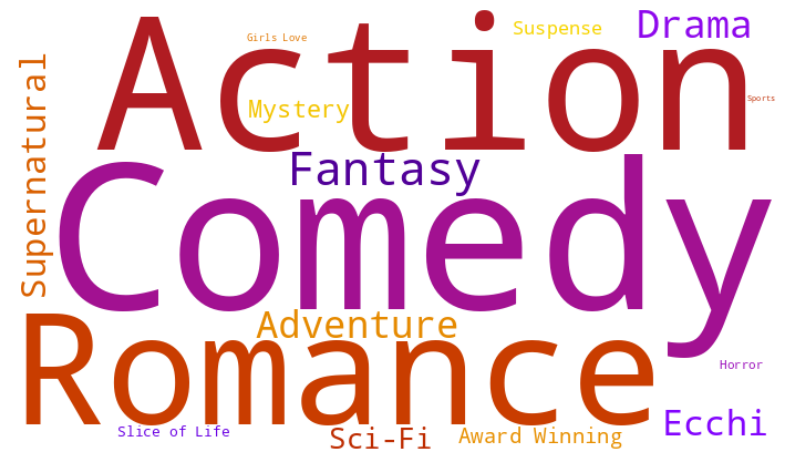

,Name,Genres
14,School Rumble,"Comedy, Romance"
54,Gakuen Alice,"Comedy, Fantasy"
56,Mahou Shoujo Lyrical Nanoha,"Action, Comedy, Drama"
57,Mahou Shoujo Lyrical Nanoha A's,"Action, Comedy, Drama"
82,Akazukin Chacha,"Adventure, Comedy, Fantasy, Romance"


In [27]:
# Get user preferences for the random user
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
pd.DataFrame(user_pref).head(5)

## Part 3: Recommending Animes for a User
#### In the final part, we recommend animes to the selected user based on the preferences of similar users. The get_recommended_animes function iterates through the list of similar users, retrieves their preferences, and identifies animes that are not present in the preferences of the selected user. It then generates a list of recommended animes along with their genres and a brief synopsis. The output is a dataframe containing the recommended animes for the user.

In [28]:
def get_recommended_animes(similar_users, user_pref, n=10):
    recommended_animes = []
    anime_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id))
        if not pref_list.empty:  # Check if user has watched any animes
            pref_list = pref_list[~pref_list["Name"].isin(user_pref["Name"].values)]
            anime_list.append(pref_list.Name.values)
            
    if len(anime_list) == 0:
        print("No anime recommendations available for the given users.")
        return pd.DataFrame()
    
    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    # Count the occurrences of each anime in the entire dataset
    anime_count = df['anime_id'].value_counts()
    
    for i, anime_name in enumerate(sorted_list.index):
        if isinstance(anime_name, str):
            try:
                anime_id = df_anime[df_anime.Name == anime_name].anime_id.values[0]
                english_name = df_anime[df_anime['Name'] == anime_name]['English name'].values[0]
                name = english_name if english_name != "UNKNOWN" else anime_name
                genre = df_anime[df_anime.Name == anime_name].Genres.values[0]
                Synopsis = df_anime[df_anime.Name == anime_name].Synopsis.values[0]
                n_user_pref = anime_count.get(anime_id, 0)  # Get the total count of users who have watched this anime
                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name, 
                    "Genres": genre, 
                    "Synopsis": Synopsis
                })
            except:
                pass
    return pd.DataFrame(recommended_animes)

In [29]:
# Get recommended animes for the random user
recommended_animes = get_recommended_animes(similar_users, user_pref, n=10)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes


> Top recommendations for user: 113945


,n,anime_name,Genres,Synopsis
0,20626,Monster,"Drama, Mystery, Suspense","Dr. Kenzou Tenma, an elite neurosurgeon recently engaged to his hospital director's daughter, is well on his way to ascending the hospital hierarchy. That is until one night, a seemingly small event changes Dr. Tenma's life forever. While preparing to perform surgery on someone, he gets a call from the hospital director telling him to switch patients and instead perform life-saving brain surgery on a famous performer. His fellow doctors, fiancée, and the hospital director applaud his accomplishment; but because of the switch, a poor immigrant worker is dead, causing Dr. Tenma to have a crisis of conscience.\n\nSo when a similar situation arises, Dr. Tenma stands his ground and chooses to perform surgery on the young boy Johan Liebert instead of the town's mayor. Unfortunately, this choice leads to serious ramifications for Dr. Tenma—losing his social standing being one of them. However, with the mysterious death of the director and two other doctors, Dr. Tenma's position is restored. With no evidence to convict him, he is released and goes on to attain the position of hospital director. \n\nNine years later when Dr. Tenma saves the life of a criminal, his past comes back to haunt him—once again, he comes face to face with the monster he operated on. He must now embark on a quest of pursuit to make amends for the havoc spread by the one he saved."
1,10680,Little Witch Academia,"Adventure, Comedy, Fantasy","For young witches everywhere, the world-renowned witch Shiny Chariot reigns as the most revered and celebrated role model. But as the girls age, so do their opinions of her—now just the mention of Chariot would get a witch labeled a child. However, undeterred in her blind admiration for Chariot, ordinary girl Atsuko Kagari enrolls into Luna Nova Magical Academy, hoping to someday become just as mesmerizing as her idol.\n\nHowever, the witch academy isn't all the fun and games Atsuko thought it would be: boring lectures, strict teachers, and students who mock Chariot plague the campus. Coupled with her own ineptness in magic, she's seen as little more than a rebel student. But when a chance finally presents itself to prove herself to her peers and teachers, she takes it, and now it's up to her to stop a rampaging dragon before it flattens the entire academy."
2,6048,Sidonia no Kishi,"Action, Sci-Fi","After destroying Earth many years ago, the alien race Gauna has been pursuing the remnants of humanity—which, having narrowly escaped, fled across the galaxy in a number of giant seed ships. In the year 3394, Nagate Tanikaze surfaces from his lifelong seclusion deep beneath the seed ship Sidonia in search of food on the upper levels, only to find himself dragged into events unfolding without his knowledge.\n\nWhen the Gauna begin their assault on Sidonia, it's up to Tanikaze—with the help of his fellow soldiers and friends Shizuka Hoshijiro, Izana Shinatose, and Yuhata Midorikawa—to defend humanity's last hope for survival, and defeat their alien foes. Sidonia no Kishi follows Tanikaze as he discovers the world that has been above him his entire life, and becomes the hero Sidonia needs."
3,9463,D-Frag!,Comedy,"The Kazama Family—a gang of three wannabe delinquents and close friends, spearheaded by Kenji Kazama, is trying to make a name for themselves at Fujou Academy. On the first day of the term, the gang finds themselves putting out a fire in the Game Development Club. Instead of thanking them, the eccentric club members attack and knock out Kenji's two friends, forcing Kenji to fight for his life. Failing to escape, the gang leader is coerced into joining the Game Development Club.\n\nAs he settles in, Kenji gets to know the four girls responsible for his provisional membership—student council president and general tyrant Chitose Karasuyama, spirited tomboy Sakura Mizukami, negligent club advisor Minami Oosawa, and the school's infamous shadow leader Roka 

# Model training (content-based filtering)

In [30]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Define a generator to compute TF-IDF matrix on the fly
tfidf_matrix_generator = tfidf.fit_transform((genre for genre in df_anime['Genres'].values.astype('U')))

# Compute cosine similarity matrix as a sparse matrix
cosine_sim_sparse = linear_kernel(tfidf_matrix_generator, tfidf_matrix_generator)

# 2: Content-Based Recommendation

In [31]:
# Function to get recommendations based on cosine similarity, genre, and ratings based on score
def get_recommendations(title, cosine_sim, df):
    idx = df_anime[df_anime['Name'] == title].index[0]

    # Compute the similarity scores between the anime at the given index and all other animes
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Filter out animes with unknown scores
    valid_scores = [x for x in sim_scores if df_anime.iloc[x[0]]['Score'] != "UNKNOWN"]

    # Sort the valid anime similarity scores based on the cosine similarity and ratings score in descending order
    sorted_scores = sorted(valid_scores, key=lambda x: (x[1], df_anime.iloc[x[0]]['Score']), reverse=True)

    # Get the top 10 similar animes (excluding the anime itself)
    top_animes = [x for x in sorted_scores if x[0] != idx][:10]

    # Extract the indices of the recommended animes
    recommended_indices = [idx for idx, _ in top_animes]
    recommended_animes = df_anime.iloc[recommended_indices][['Name', 'Genres', 'Score']]
    return recommended_animes

In [32]:
# Example usage: Get recommendations for an anime
anime_title = 'Kono Subarashii Sekai ni Shukufuku wo!'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "Kono Subarashii Sekai ni Shukufuku wo!":


,Name,Genres,Score
14578,Kono Subarashii Sekai ni Shukufuku wo! Movie: Kurenai Densetsu,"Adventure, Comedy, Fantasy",8.45
11572,Kono Subarashii Sekai ni Shukufuku wo! 2,"Adventure, Comedy, Fantasy",8.27
6241,Doraemon Movie 31: Shin Nobita to Tetsujin Heidan - Habatake Tenshi-tachi,"Adventure, Comedy, Fantasy",8.14
12451,Kono Subarashii Sekai ni Shukufuku wo! 2: Kono Subarashii Geijutsu ni Shukufuku wo!,"Adventure, Comedy, Fantasy",8.03
502,Slayers Next,"Adventure, Comedy, Fantasy",8.02
1068,Slayers Try,"Adventure, Comedy, Fantasy",7.81
11859,Little Witch Academia (TV),"Adventure, Comedy, Fantasy",7.81
12531,Mahoujin Guruguru (2017),"Adventure, Comedy, Fantasy",7.81
7105,Little Witch Academia,"Adventure, Comedy, Fantasy",7.8
8061,Little Witch Academia: Mahoujikake no Parade,"Adventure, Comedy, Fantasy",7.75


In [33]:
anime_title = 'One Piece'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "One Piece":


,Name,Genres,Score
16617,Bleach: Sennen Kessen-hen,"Action, Adventure, Fantasy",9.07
6456,Hunter x Hunter (2011),"Action, Adventure, Fantasy",9.04
115,Hunter x Hunter,"Action, Adventure, Fantasy",8.41
116,Hunter x Hunter: Original Video Animation,"Action, Adventure, Fantasy",8.31
1574,Naruto: Shippuuden,"Action, Adventure, Fantasy",8.26
19600,Jigokuraku,"Action, Adventure, Fantasy",8.26
118,Hunter x Hunter: Greed Island Final,"Action, Adventure, Fantasy",8.25
23239,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka IV: Fuka Shou - Yakusai-hen,"Action, Adventure, Fantasy",8.24
7799,Magi: The Kingdom of Magic,"Action, Adventure, Fantasy",8.22
14699,One Piece Movie 14: Stampede,"Action, Adventure, Fantasy",8.22
